# Müller Brown II

## Previously on Müller Brown I

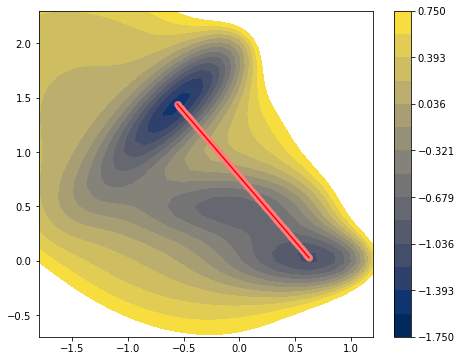

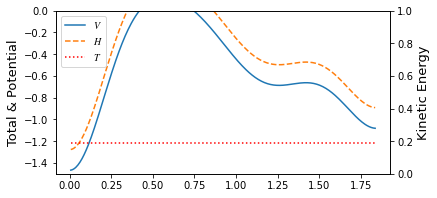

In [1]:
import numpy as np
from taps.paths import Paths
from taps.models import MullerBrown
from taps.coords import Cartesian
from taps.visualize import view

N = 300

x = np.linspace(-0.55822365, 0.6234994, N)
y = np.linspace(1.44172582, 0.02803776, N)

coords = Cartesian(coords=np.array([x, y]))
model = MullerBrown()
paths = Paths(coords=coords, model=model)
view(paths, viewer='MullerBrown')

## Müller Brown II
 Here, we introduce a less fun but more practical tools in TAPS, `Projector`. Optimizing a pathway of an atomic system requires vast amount of computational time on the configuration space searching which in many case unfeasible. `Projector` class manipulates the coordinates system into smaller (usually) dimension so that user can reduce the configuration space for searching. For example, user can use the `Mask` projector that effectively hide some atoms from the `PathFinder` object so that position of some atoms can be fixed while optimizing the pathway. Surface reaction may use it useful restriction for a slab. Or user can optimize only the sine components of the pathway so user can effectively reduce the space to search. Or one may want to do it both. In the `Projector` class, there are three keywords `domain`, `codomain`, and `pipeline`. Unfortunately, `domain` and `codomain` keywords are exists as future usage. They are intended to controls the class of the pathway while prjoection into one to the other but currently it only exists as a concept. The third keyword, `pipeline` binds the multiple `Projector` class into one so that user can use multiple projector like one. For example, user can put `Sine` projector into the `Mask`s pipeline so that some atoms are ignored and being fourie transformed. For simplicity, we are going to demonstrate only the `Sine` projector here. 
 
 Unfortunately, using `Sine` projector is not an automatic procedure. User has to put 4 additional kewords, total length of the `coords`, $N$, a number of sine components $N_k$, image of initial step `init`, and final reactant `fin`. `Sine` projector uses `scipy.fftpack` to conduct fast fourier transform. `Sine` use type 1 sine transformation, where
 
$$y_k = 2 \sum_{n=0}^{N-1} x_n \sin\left(\frac{\pi(k+1)(n+1)}{N+1}\right)$$

We have to fix the both end to 0. That gives us stability when removing high frequency components. Since it assumes the both end as 0, coordinate at both end should be given explcitley. Thus, user should manually specify the coordinate. Script below shows creation of the `Sine` projector and manipulate a sine components of that coordinate and visualize how it effected. 

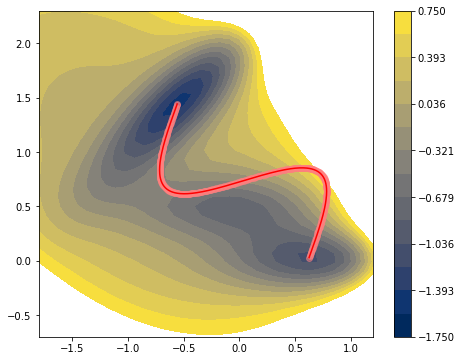

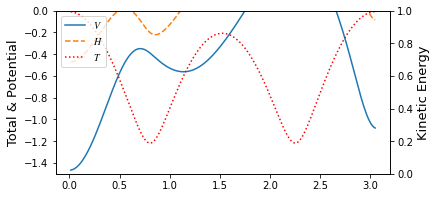

In [2]:
from taps.projectors import Sine
# We are going to use only the 30% of the coordinate information
Nk = N - 210
prj = Sine(N=N, Nk=Nk, init=paths.coords[:, 0].copy(), fin=paths.coords[:, -1].copy())
sine_coords = prj.x(paths.coords(index=np.s_[..., 1:-1]))

# Sine component manipulation
sine_coords[:, 1] = -5

new_coords = prj.x_inv(sine_coords)

paths.coords.coords[..., 1:-1] = new_coords.coords
view(paths, viewer='MullerBrown')

## Pathway optimization on the sine components.

 Previouse MB example was conducted on the 2D Cartesian coordinate directly. In this example, we are going to use `Sine` projector during optimization process. Setting and kewords are same with previous example, with additional `prj_search=True` and `prj=prj` keyword inserted in `DAO`. 

In [3]:
from taps.pathfinder import DAO

search_kwargs = {"method":"L-BFGS-B",
                  "options": {'disp': None,
                              'maxcor': 20,
                              'ftol': 2.220446049250313e-4,
                              'gtol': 1e-03,
                              'eps': 5e-6, 
                              'maxfun': 1000,
                              'maxiter': 1000,
                              'iprint': -1, 'maxls': 100,
                              'finite_diff_rel_step': 1e-6}}

finder = DAO(Et=-0.6, muE=1., tol=1e-2, gam=1.,
             action_name = ['Onsager Machlup', "Energy conservation"],
             prj_search=True,
             search_kwargs=search_kwargs, 
             prj=prj)

paths.finder = finder
paths.coords.epoch=6
paths.search()


Action name  : Onsager Machlup + Energy conservation
Target energy: -0.6
Target type  : manual
muE          : 1.0
gamma        : 1.0
            Iter   nfev   njev        S   dS_max
converg :    159    167    167   4.6460   0.4386
converg :    161    172    172   4.6443   0.2506
jac_max > tol(0.01); Run without gradient
converg :    162    176    176   4.6438   0.2196


Below text is output of previous example, where cartesian coordinates were directly used as input $(N=300)$. But here we used only 30% $(Nk=90)$ of the coordinate information during optimization process. From that we get huge amount of gain in computatational cost but a little sacrifice of its accuracy without losing continuity required by action calculation. 

## Results in the previous example, Müller Brown I 
```
Action name  : Onsager Machlup + Energy conservation
Target energy: -0.45
Target type  : manual
muE          : 1.0
gamma        : 1.0
            Iter   nfev   njev        S   dS_max
converg :   1011   1069   1069   2.1970   0.9060
converg :   1013   1075   1075   2.1955   0.4221
jac_max > tol(0.05); Run without gradient
converg :   1014   1080   1080   2.1951   0.4931
```


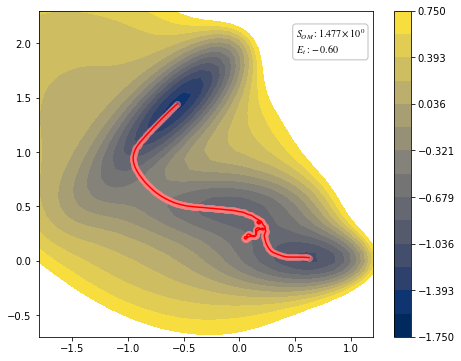

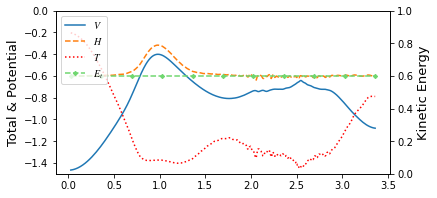

In [4]:
view(paths, viewer="MullerBrown")

You can see through profile of the trajectory that it has lack of high frequency components. 

## Database construction

To utilize the data while we calculate the pathways, construction of proper database is postulated. `ImageData` class can save the calculation results of atomic or model system using below. 

```python
from taps.db import ImageData
imgdata = ImageData()
imgdata.add_data(paths, coords=(DxN or 3xDxN)size array)
```



TAPS aims for string method pathway calculation more effcient manner. meaning we insert some muller. In order to use  I had to made the data abse

In [5]:
from taps.db import ImageData
imgdata = ImageData("mullerbrown.db")
imgdata.add_data(paths, coords=paths.coords[..., [0, -1]])

{'image': [1, 2]}

## Gaussian Potential

With the data we constructed in this example, we are going to use it to construct Gaussian PES. Using only the 3 point of data, `init`, `fin` and middle point of the trajectory, We conconstruct the Gaussian Potential.

Kernel we are going to use here is standard (square exponential) kernel. Kernel looks like, 

$$ K(x_1, x_2) = \sigma_f e^{(x_1-x_2)^2/2l^2}$$

with zero mean, expectation value and covariance of the potential is

$$\mu = K_* (K_y+\sigma_n)^{-1} \mathbf{Y} $$
$$\Sigma = K_{**} + K_* K_y^{-1} K_*^{-1}$$ 

In the process of regression, where minimize the log likelihood. 


In [6]:
#import warnings
#warnings.filterwarnings('error')

from taps.models import Gaussian
hyperparameters = {'sigma_f': 1, 'sigma_n^f': 1e-8, 'sigma_n^e':1e-6,
                   'l^2': 1}
hyperparameters_bounds = {'sigma_f': (1e-4, 1e2), 'sigma_n^f': (1e-8, 1e-6), 
                          'sigma_n^e':(1e-6, 1e-4), 'l^2': (1e-1, 4)}

paths.imgdata = imgdata
model = Gaussian(real_model=model,
                 hyperparameters=hyperparameters,
                 hyperparameters_bounds=hyperparameters_bounds)
paths.model = model
paths.add_data(index=[0, -1])

{'image': [1, 2]}

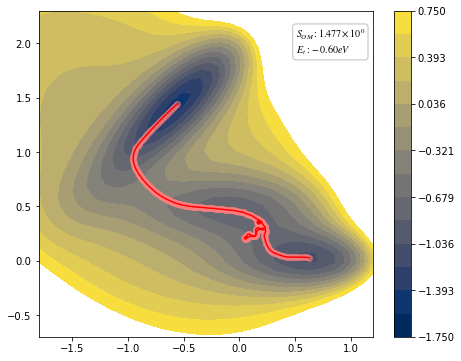

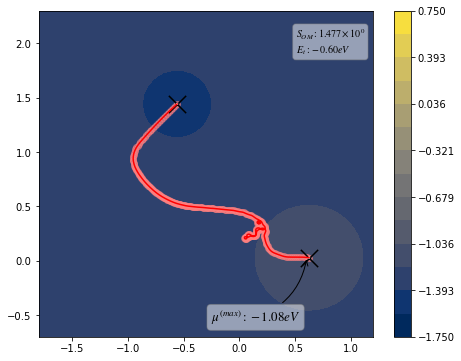

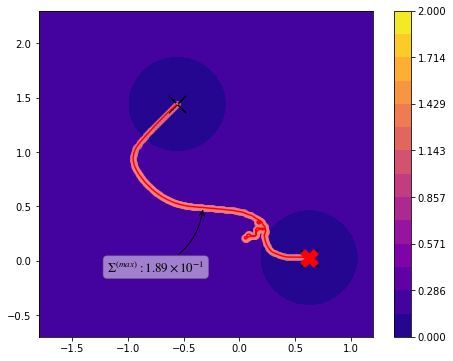

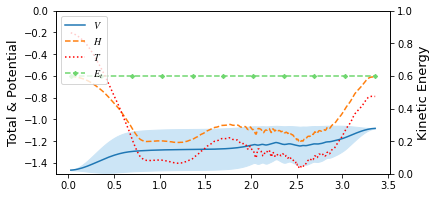

In [7]:
view(paths, viewer="MullerBrown", gaussian=True)

## $\mu$ and $\Sigma$ Maps

You can see the second and third map images that depicting mean expectation value, $\mu$, and uncertainty map, $\Sigma$ with additional information plotted on the map such as maximum uncertainty or maximum estimated potential. 

 It looks totally different from real PES, the first map. We will shows you how we approximate the PES near the minimum energy pathway (MEP) to real one. We will finish this tutorial by optimizing the pathway based on the Gaussian PES. 

Action name  : Onsager Machlup + Energy conservation
Target energy: -1.2
Target type  : manual
muE          : 1.0
gamma        : 1.0
            Iter   nfev   njev        S   dS_max
converg :    495    527    527   1.3732   0.1439
converg :    496    532    532   1.3731   0.0499
jac_max > tol(0.01); Run without gradient
converg :    497    537    537   1.3730   0.0871


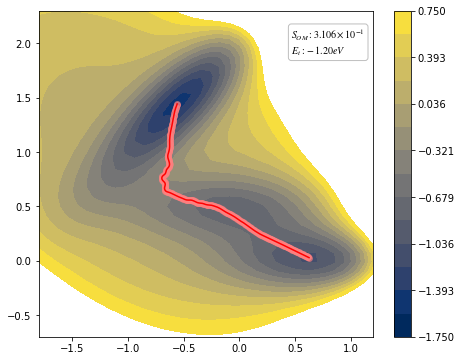

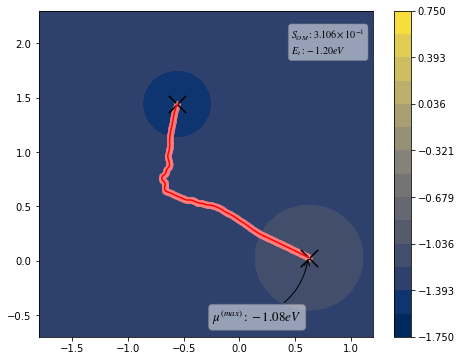

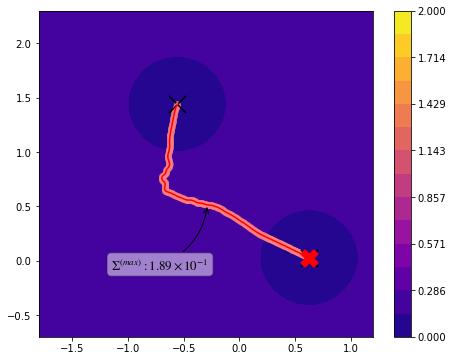

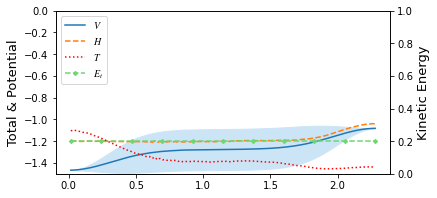

In [9]:
paths.finder.Et = -1.2
paths.search()
view(paths, viewer="MullerBrown", gaussian=True)